In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

import os, sys
sys.path.append('../code')

from retina import *

/home/oalenkin/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### data reading

In [2]:
data = pd.read_csv('../data/hits.csv', index_col=0)

# Stage 2.1

### test function distance_between_skew_lines()

In [3]:
from retina import distance_between_skew_lines, points2vec, get_track_params, params2vec

In [4]:
real = []
exp = []
for event_i in set(data.EventID.values):
    event = data[data.EventID==event_i]
    track1 = event[(event.TrackID==2)&(event.StatNb<3)]
    if len(track1)>1:
        x0=track1.X.values[0]
        x1=track1.X.values[1]
        y0=track1.Y.values[0]
        y1=track1.Y.values[1]
        z0=track1.Z.values[0]
        z1=track1.Z.values[1]
    else:
        continue
    track_point, track_direction = points2vec(np.array([x0, y0, z0, x1, y1, z1]))
    #x0, l, y0, m = get_track_params(track1, 2)
    #track_point, track_direction = params2vec(l, x0, m, y0)
    for i in range(len(track1)):
        params = track1[['Wx1', 'Wy1', 'Wz', 'Wx2', 'Wy2', 'Wz']].values[i]
        tube_point, tube_direction = points2vec(params)
        exp.append(distance_between_skew_lines(track_point, track_direction, tube_point, tube_direction))
        real.append(track1.dist2Wire.values[i])
        
    track2 = event[(event.TrackID==3)&(event.StatNb<3)]
    if len(track2)>1:
        x0=track2.X.values[0]
        x1=track2.X.values[1]
        y0=track2.Y.values[0]
        y1=track2.Y.values[1]
        z0=track2.Z.values[0]
        z1=track2.Z.values[1]
    else:
        continue
    track_point, track_direction = points2vec(np.array([x0, y0, z0, x1, y1, z1]))
    #x0, l, y0, m = get_track_params(track2, 3)
    #track_point, track_direction = params2vec(l, x0, m, y0)
    for i in range(len(track2)):
        params = track2[['Wx1', 'Wy1', 'Wz', 'Wx2', 'Wy2', 'Wz']].values[i]
        tube_point, tube_direction = points2vec(params)
        exp.append(distance_between_skew_lines(track_point, track_direction, tube_point, tube_direction))
        real.append(track2.dist2Wire.values[i])

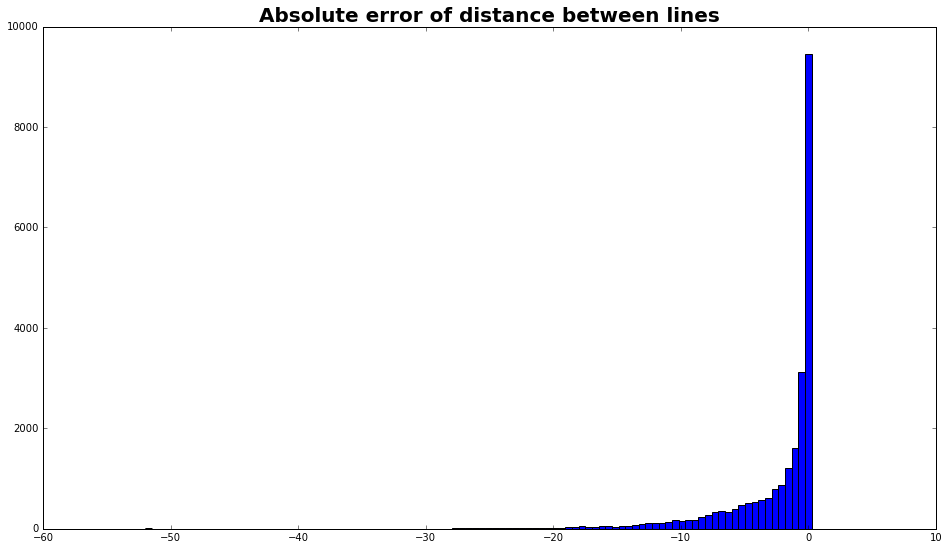

In [5]:
plt.figure(figsize=(16,9))
plt.title("Absolute error of distance between lines", fontsize=20, fontweight='bold')
hist_arr = plt.hist(np.array(real)-np.array(exp), bins=100)

Result is strange. A lot of distances from track to its tubes were found with huge error. May be realization is the reason of this effect. May be tracks reconstructed from 2 points are wrong.

### how to use artifitial_retina_response()

In [6]:
from retina import artifitial_retina_response

In [7]:
artifitial_retina_response([0, 0, 0, 0], event[['Wx1', 'Wy1', 'Wz', 'Wx2', 'Wy2', 'Wz']].values, 0.5)

array(1.3793074130541081e-163)

# Stage 2.2

# 2D projections

In [8]:
from retina import plot_artifitial_retina_response, params2vec

In [29]:
event = data[data.EventID==2]
event_before_magnet = event[event.StatNb<3]

In [10]:
size = 20
ms = np.linspace(-0.5, 0.5, size)
y0s = np.linspace(-500, 500, size)
ls = np.linspace(-0.5, 0.5, size)
x0s = np.linspace(-250, 250, size)

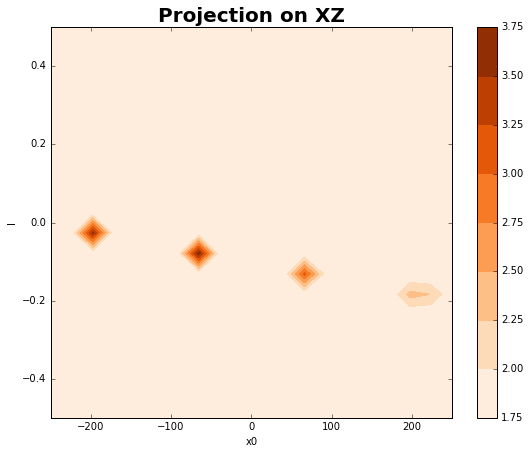

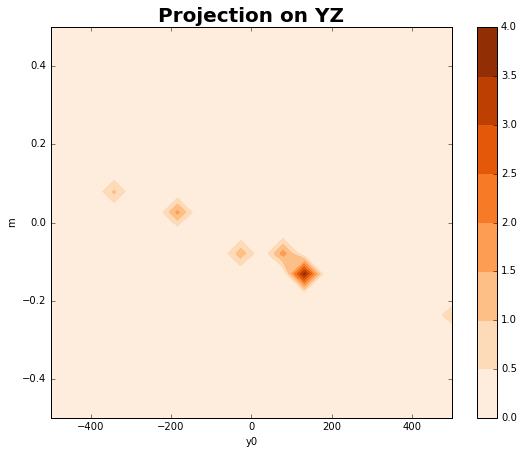

In [11]:
projections = plot_artifitial_retina_response(event_before_magnet, [x0s, ls, y0s, ms], 1)

In [12]:
from retina import get_track_params

In [22]:
track1 = get_track_params(event_before_magnet, 2)
track1

[-71.93019431301461,
 -0.019083404599996478,
 -151.87648248209635,
 0.0094009400000002064]

In [23]:
track2 = get_track_params(event_before_magnet, 3)
track2

[-90.378411160590431,
 0.0015087299923260595,
 -115.21658250100649,
 -0.042832547618818356]

# Stage 2.3

# Parameters distribution

In [15]:
y0s = []
ms = []
x0s = []
ls = []
for event_i in set(data.EventID.values):
    event = data[data.EventID==event_i]
    track1 = event[(event.TrackID==2)&(event.StatNb<3)]
    if len(track1)>1:
        x0=track1.X.values[0]
        x1=track1.X.values[1]
        y0=track1.Y.values[0]
        y1=track1.Y.values[1]
        z0=track1.Z.values[0]
        z1=track1.Z.values[1]
    else:
        continue
    track_point, track_direction = points2vec(np.array([x0, y0, z0, x1, y1, z1]))
    params = vec2params([track_point, track_direction])
    y0s.append(params[2])
    ms.append(params[3])
    x0s.append(params[0])
    ls.append(params[1])
    
    track2 = event[(event.TrackID==3)&(event.StatNb<3)]
    if len(track2)>1:
        x0=track2.X.values[0]
        x1=track2.X.values[1]
        y0=track2.Y.values[0]
        y1=track2.Y.values[1]
        z0=track2.Z.values[0]
        z1=track2.Z.values[1]
    else:
        continue
    track_point, track_direction = points2vec(np.array([x0, y0, z0, x1, y1, z1]))
    params = vec2params([track_point, track_direction])
    y0s.append(params[2])
    ms.append(params[3])
    x0s.append(params[0])
    ls.append(params[1])
y0s = np.array(y0s)
ms = np.array(ms)
x0s = np.array(x0s)
ls = np.array(ls)

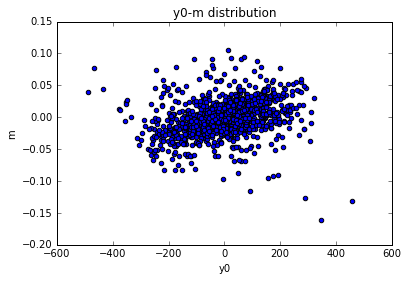

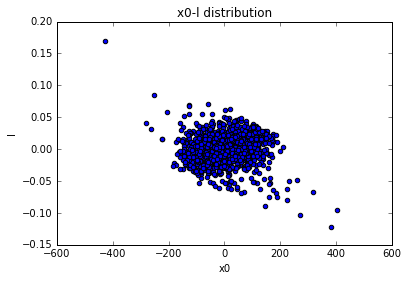

In [16]:
plt.figure()
plt.title("y0-m distribution")
plt.scatter(y0s, ms)
plt.xlabel('y0')
plt.ylabel('m')
plt.figure()
plt.title("x0-l distribution")
plt.scatter(x0s, ls)
plt.xlabel('x0')
plt.ylabel('l')

# Track finding demonstaration

In [7]:
from retina import RetinaTrackReconstruction

In [30]:
retina = RetinaTrackReconstruction()

In [31]:
array_of_initial_parameters = []
for i in np.linspace(-500, 500, 100):
    array_of_initial_parameters.append([0, 0, i, 0])
array_of_initial_parameters = np.array(array_of_initial_parameters)

In [32]:
dots_array = retina.fit(event_before_magnet[['Wx1', 'Wy1', 'Wz', 'Wx2', 'Wy2', 'Wz']].values, \
                        array_of_initial_parameters)

In [33]:
new_dots_array = []
for i in dots_array:
    new_dots_array.append([vec2params(i)])
new_dots_array = np.array(new_dots_array)

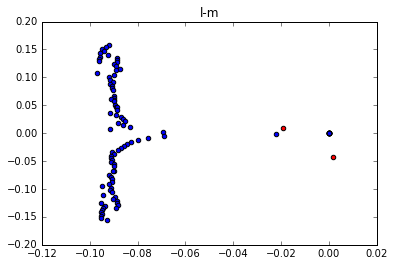

In [34]:
plt.scatter(new_dots_array[:, 0, 1], new_dots_array[:, 0, 3])
plt.scatter(track1[1], track1[3], c='red')
plt.scatter(track2[1], track2[3], c='red')
plt.title('l-m')

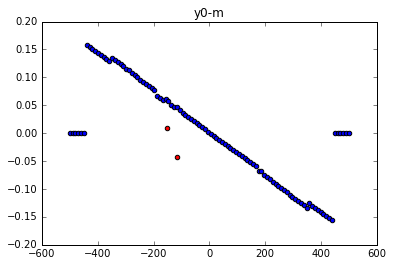

In [35]:
plt.scatter(new_dots_array[:, 0, 2], new_dots_array[:, 0, 3])
plt.scatter(track1[2], track1[3], c='red')
plt.scatter(track2[2], track2[3], c='red')
plt.title('y0-m')

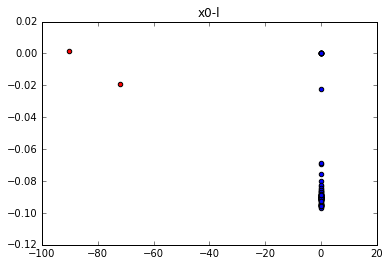

In [36]:
plt.scatter(new_dots_array[:, 0, 0], new_dots_array[:, 0, 1])
plt.scatter(track1[0], track1[1], c='red')
plt.scatter(track2[0], track2[1], c='red')
plt.title('x0-l')

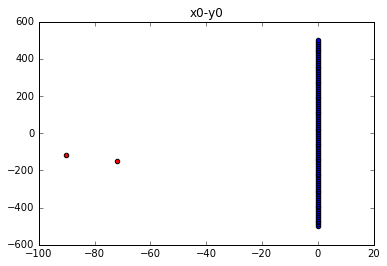

In [37]:
plt.scatter(new_dots_array[:, 0, 0], new_dots_array[:, 0, 2])
plt.scatter(track1[0], track1[2], c='red')
plt.scatter(track2[0], track2[2], c='red')
plt.title('x0-y0')

In [9]:
new_dots_array = []
for dots in dots_array:
    new_dots = []
    for dot in dots:
        new_dot = np.array(vec2params(dot[0], dot[1]))
        new_dots.append(new_dot)
    new_dots_array.append(np.array(new_dots))

In [6]:
size = 10
ms = np.linspace(0.009, 0.01, size)
y0s = np.linspace(-153, -149, size)
ls = np.linspace(-0.021, -0.017, size)
x0s = np.linspace(-75, -65, size)
grid = np.ndarray(shape=(len(x0s), len(ls), len(y0s), len(ms)))
for i in range(len(x0s)):
    for j in range(len(ls)):
        for s in range(len(y0s)):
            for t in range(len(ms)):
                grid[i, j, s, t] = artifitial_retina_response(ls[j], x0s[i], ms[t], y0s[s],\
                                                              event_before_magnet[['Wx1', 'Wy1', 'Wz', 'Wx2', 'Wy2', 'Wz']].values, 1)
                    
projection_on_yz = np.zeros((grid.shape[3], grid.shape[2]), dtype="float64")
for s in range(grid.shape[3]):
        for t in range(grid.shape[2]):
            projection_on_yz[s, t] = np.max(grid[:, :, t, s])

(0.009, 0.01)

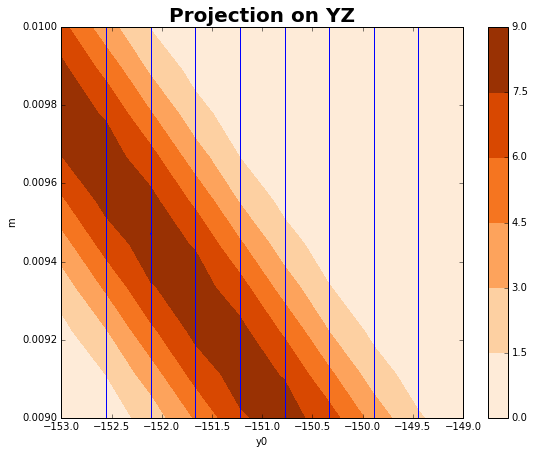

In [24]:
fig2 = plt.figure(figsize=(9, 7))
plt.title("Projection on YZ", fontsize=20, fontweight='bold')
#_ = plt.imshow(projection_on_yz, aspect='auto', cmap="Blues", extent=(ms.min(), ms.max(), y0s.max(), y0s.min()))
_ = plt.contourf(y0s, ms, projection_on_yz, cmap=plt.cm.Oranges)
plt.xlabel("y0")
plt.ylabel("m")
plt.colorbar()

for new_dots in new_dots_array:
    for i in range(len(new_dots)-1):
        plt.plot([new_dots[i][2], new_dots[i+1][2]], [new_dots[i][3], new_dots[i+1][3]], c='blue')
        
plt.xlim([-153, -149])
plt.ylim([0.009, 0.01])